In [78]:
%pip install flask tensorflow resampy librosa opencv-python pydub

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: flask in c:\users\usher\appdata\local\programs\python\python311\lib\site-packages (3.1.0)




[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from flask import Flask, render_template, request
import tensorflow as tf

In [3]:
# Load the trained model
model = tf.keras.models.load_model('./cnn.keras')

In [3]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,398,998 (257.11 MB)

 Trainable params: 33,699,498 (128.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,699,500 (128.55 MB)

In [4]:
from numpy import ndarray
import numpy as np
import librosa
import matplotlib.pyplot as plt
import cv2 as cv
import io
import base64

HOP_LENGTH = 512        # number of samples between successive frames
WINDOW_LENGTH = 512     # length of the window in samples
N_MEL = 128             # number of Mel bands to generate


def spectrogram_fixed_length(audio, rate, total_samples = 128) -> ndarray:
    spectrogram = librosa.feature.melspectrogram(
        y = audio, 
        sr=rate, 
        hop_length=HOP_LENGTH, 
        win_length=WINDOW_LENGTH,
        n_fft=512
    )

    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    spectrogram_length = spectrogram_db.shape[1]

    if spectrogram_length != total_samples:
        spectrogram_db = librosa.util.fix_length(
            spectrogram_db, size=total_samples, axis=1,

            #constant_values=(0, -80)
        )
    
    return spectrogram_db


def generate_spectrogram(audio, sample_rate):
    spectrogram = spectrogram_fixed_length(audio, sample_rate)
    librosa.display.specshow(spectrogram, cmap='viridis')
    plt.axis('tight')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("uploads/spectrogram.png", bbox_inches="tight", pad_inches=0.0)



# TODO: use sliding window
def preprocess_audio(audio):
    DURATION = 3
    audio, sample_rate = librosa.load(audio, duration=DURATION, res_type='kaiser_fast')
    generate_spectrogram(audio, sample_rate)
   
    # fig, ax = plt.subplots(figsize=(8, 6))
    # fig.axis('tight')
    # fig.axis('off')
    # fig.tight_layout()
    # spectrogram = librosa.display.spectrogram(spectrogram)
    # plt.close(fig)

    IMG_SIZE = 256

    img_array = cv.imread("uploads/spectrogram.png")
    new_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))

    print("Done!")

    return np.array(new_array).reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255


 * Serving Flask app 'Audio Classifier'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [07/Apr/2025 16:00:30] "GET / HTTP/1.1" 200 -


Done!
predicting...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


127.0.0.1 - - [07/Apr/2025 16:00:32] "POST /classify HTTP/1.1" 200 -


[1.7236784e-09 1.1909266e-07 1.8971175e-03 2.3328667e-03 5.3042375e-05
 9.9373356e-06 3.7990300e-09 5.6135854e-05 9.9478096e-01 8.6978206e-04]
{'air_conditioner': 1.7236784222163237e-07, 'car_horn': 1.1909266106613359e-05, 'children_playing': 0.18971174722537398, 'dog_bark': 0.2332866657525301, 'drilling': 0.005304237492964603, 'engine_idling': 0.0009937335562426597, 'gun_shot': 3.7990299794898874e-07, 'jackhammer': 0.005613585381070152, 'siren': 99.4780957698822, 'street_music': 0.08697820594534278}
audio/mpeg


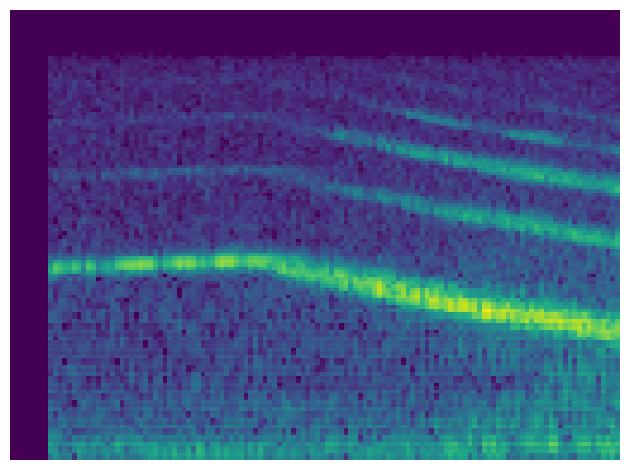

In [94]:
import os
from pydub import AudioSegment

app = Flask("Audio Classifier")
app.config['UPLOAD_FOLDER'] = 'uploads/'

@app.route('/')
def index():
    return render_template('./index.html')

# @app.route('/upload', methods=['POST'])
# def upload_file():
#     if 'file' not in request.files:
#         return 'No file uploaded', 400

#     file = request.files['file']

#     if file.filename == '':
#         return 'No file selected', 400

#     if file:
#         filename = file.filename
#         file.save(os.path.join(app.config['UPLOAD_FOLDER'], filename))
#         generate_spectrogram(os.path.join(app.config['UPLOAD_FOLDER'], filename))
#         return 'File uploaded and spectrogram generated', 200

@app.route('/classify', methods=['POST'])
def classify():
    # Get the audio file from the request
    audio_file = request.files['audio_file']

    # Process the audio file using your trained model
    audio_data = preprocess_audio(audio_file)
    print("predicting...")
    prediction = model.predict(audio_data)

    
    LABELS = [
        "air_conditioner",
        "car_horn",
        "children_playing",
        "dog_bark",
        "drilling",
        "engine_idling",
        "gun_shot",
        "jackhammer",
        "siren",
        "street_music"
    ]

    p = {}
    pred = prediction.flatten()
    print(pred)
    for (index, label) in enumerate(LABELS):
        p[label] = float(pred[index] * 100.0)

    print(p)

    
    predicted = np.argmax(prediction)

    file = open("uploads/spectrogram.png", 'rb')
    image_buffer = file.read()

    print(audio_file.mimetype)
    spectrogram = base64.b64encode(image_buffer).decode('utf-8')


    # mp3_bytes = io.BytesIO()
    # audio = AudioSegment.from_file(audio_file.read())
    # audio.export(mp3_bytes, format='mp3')
    # # mp3_data = mp3_bytes.getvalue()
    
    # audio_data = base64.b64encode(mp3_bytes.read()).decode('utf-8')
    
    # Return the classification result
    return {
        'prediction': LABELS[predicted],
        'spectrogram': spectrogram, 
        # 'audio': audio_data,
        # 'audio_mime': audio_file.mimetype,
        'predictions': p,
    }

app.run()


 * Serving Flask app 'Audio Classifier'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [02/Apr/2025 14:43:57] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Apr/2025 14:44:03] "GET /?audio_file=siren.wav HTTP/1.1" 200 -
127.0.0.1 - - [02/Apr/2025 14:44:33] "GET /?audio_file=silence.wav HTTP/1.1" 200 -
